# Day 19 - Kernel Methods

Here we are going to discuss three things:
- Kernel methods
- QSVM with PennyLane
- Comparison between QSVM and variational circuits

## Kernel Methods
- maps data to a higher-dimensional feature space, and is the core of <b>Support Vector Machines (SVMs)</b>
- **Kernel functions**: $k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j)\rangle$, where
    - $k$ is the kernel function
    - $\vec{x}_i, \vec{x}_j$ are $n$-dimensional input
    - $f$ is a map from $n$-demensional space to $m$-dimensional space
    - and $\langle ., .\rangle$ denotes the inner product
- **Quantum Kernels**: using quantum feature map to perform the kernel trick, and can be plugged into classical SVM.
$K_{ij} = |\langle \phi(\vec{x}_i), \phi(\vec{x}_j)\rangle|^2$
    where
    - $K_{ij}$ is the kernel matrix
    - $\vec{x}_i, \vec{x}_j$ are $n$-dimensional input
    - $\phi(\vec{x})$ is the quantum feature map
    - and $|\langle ., .\rangle|^2$ is the overlap of two quantum states

<!-- Qiskit: QSVC class, PEGASOS QSVC, Quantum Kernel Training -->

## QSVM using Pennylane

- Kernel based trainings bypass the processing and measurement parts of variational circuits, and only depends on the data encoding.
- If loss is [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), the kernel method corresponds to standard SVM. Other convex loss functions lead to more general variations of SVMs.

Note:
- Hinge Loss: $l(y) = max(0, 1-t.y)$, where y_true is $t=\pm1$, and y is the raw prediction (not the predicted label).

In [33]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

### Dataset

We need a data to perform out experiments, and for simplicity we use the **IRIS** dataset.

In [42]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only: first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

We now need to encode the classical features into quantum space. For that, we use **Angle Embedding**, which requires as many qubits as there are features.

In [35]:
n_qubits = len(X_train[0])
n_qubits

4

In [37]:
dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

kernel(X_train[0], X_train[0])

array(1.)

In [38]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [39]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

In [40]:
with dev_kernel.tracker:
    predictions = svm.predict(X_test)
    accuracy_score(predictions, y_test)

In [41]:
dev_kernel.tracker.totals

{'executions': 1875, 'batches': 1875, 'batch_len': 1875}

In [10]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

In [11]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) / (len(X_train) + len(X_test)))

7500

In [12]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

In [13]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) / (len(X_train) + len(X_test)))

7500

# A Variational Training Example

In [24]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [25]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

step 0 , loss 1.1719823399387188
step 10 , loss 0.813144414460972
step 20 , loss 0.7404924633324822
step 30 , loss 0.6813387353463816
step 40 , loss 0.545990678824913
step 50 , loss 0.5047287511438645
step 60 , loss 0.4543728731754838
step 70 , loss 0.49299826271353825
step 80 , loss 0.48046629554338927
step 90 , loss 0.5386228844071614
accuracy on test set: 0.96


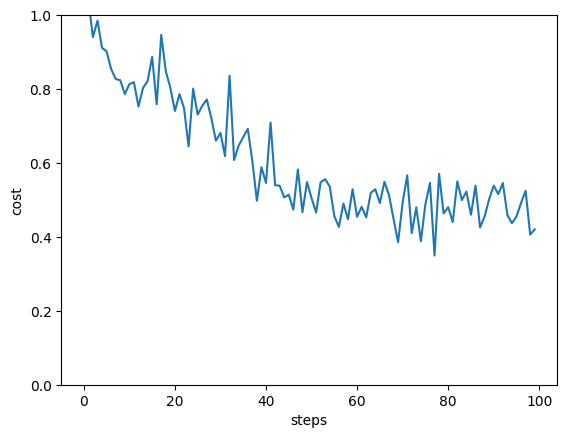

In [26]:
n_layers = 2
batch_size = 20
steps = 100

with dev_var.tracker:
    trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)
    pred_test = quantum_model_predict(X_test, trained_params, trained_bias)

print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [27]:
dev_var.tracker.totals['executions']

74025

In [29]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) / (len(X_train) + len(X_test)),
    batch_size=batch_size,
)

96025

In [31]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) / (len(X_train) + len(X_test)),
    batch_size=batch_size,
)

2025

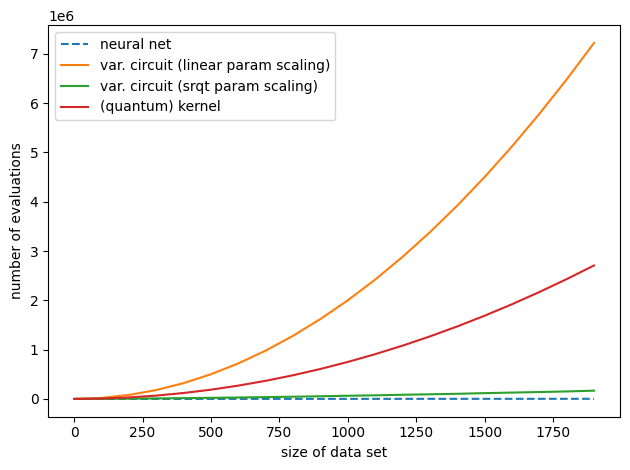

In [32]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:
    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M, shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()